In [1]:
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import itertools
from mycolorpy import colorlist as mcp
import random
import matplotlib.cm
import glob
from matplotlib import font_manager
from utils.utils import *
from matplotlib_venn import venn2, venn2_circles

In [2]:
peaks = pd.read_csv('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/ATAC/data/peaks/union_peaks_meta.bed',sep='\t')

In [3]:
peaks.describe()

start           end     width          score   
count  4.439730e+05  4.439730e+05  443973.0  443973.000000  \
mean   7.901447e+07  7.901497e+07     501.0      19.712026   
std    5.666549e+07  5.666549e+07       0.0      28.293917   
min    1.028700e+04  1.078700e+04     501.0       1.001790   
25%    3.309424e+07  3.309474e+07     501.0       5.395660   
50%    6.906486e+07  6.906536e+07     501.0      10.268800   
75%    1.170230e+08  1.170235e+08     501.0      22.133200   
max    2.489268e+08  2.489273e+08     501.0     507.427000   

       replicateScoreQuantile  groupScoreQuantile  Reproducibility   
count           443973.000000       443973.000000    443973.000000  \
mean                 0.647548            0.525732         3.591088   
std                  0.235570            0.280767         1.232885   
min                  0.004000            0.000000         2.000000   
25%                  0.501000            0.298000         2.000000   
50%                  0.679000            0.541000         4.000000   
75%                  0.839000            0.766000         5.000000   
max                  1.000000            0.999000         5.000000   

       distToGeneStart     distToTSS             GC            idx         N  
count     4.439730e+05  4.439730e+05  443973.000000  443973.000000  443973.0  
mean      7.996782e+04  2.506570e+04       0.472666   11547.233674       0.0  
std       1.371460e+05  4.720096e+04       0.092397    8343.960045       0.0  
min       0.000000e+00  0.000000e+00       0.219600       1.000000       0.0  
25%       8.439000e+03  1.963000e+03       0.405200    4826.000000       0.0  
50%       3.351500e+04  8.750000e+03       0.459100    9992.000000       0.0  
75%       9.240200e+04  2.748900e+04       0.526900   16920.000000       0.0  
max       4.840695e+06  2.177657e+06       0.882200   39424.000000       0.0

# Figure 4a: Celltype peak categories

In [7]:
peaks_dir = '/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/ATAC/data/peaks_df/'

arr = np.zeros((7,4))
for ii,celltype in enumerate(['EXC','OLI','INH','OPC','MIC','END','AST']):
    df = pd.read_csv(peaks_dir+f'{celltype}.peaks_df.csv',sep=',')
    vals = df.peakType.value_counts().values
    arr[ii] = vals
    print(celltype,vals.sum())

EXC 150000
OLI 147246
INH 147156
OPC 143406
MIC 119119
END 104290
AST 102500


In [8]:
# Total number of peaks
total = arr.sum()
total

913717.0

In [9]:
# percent intronic
arr[:,0].sum()/total

0.5112523899631943

In [10]:
# percent distal
arr[:,1].sum()/total

0.26151313809418014

In [11]:
arr = arr/1e3

In [12]:
arr = pd.DataFrame(arr,index=['EXC','OLI','INH','OPC','MIC','END','AST'],columns=['Intronic','Distal','Promoter','Exonic'])

In [13]:
celltypes = ['EXC','OLI','INH','OPC','MIC','END','AST']
colors = [celltype_colors[x] for x in celltypes]
fc_colors = []
for a in [1,0.7,0.4,0.1]:
    for c in colors:
        fc_color = (np.append(list(matplotlib.colors.to_rgb(c)),a))
        fc_colors.append(fc_color)

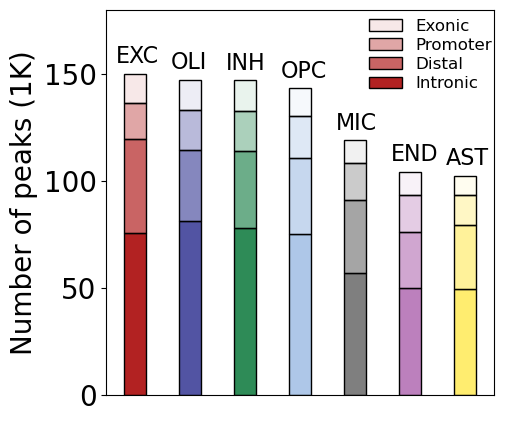

In [14]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size']= '20'

plt.rcParams.update({'hatch.color': 'white'})

fig, ax = plt.subplots(figsize=(5,5))
ax.set_ylabel('Number of peaks (1K)')
ax.set_ylim([0,180])
ax.get_xaxis().set_visible(False)

ax.bar(celltypes,arr.values[:,0],width=0.4,label='Intronic',color=fc_colors[:7],ec=(0,0,0,1))
ax.bar(celltypes,arr.values[:,1],bottom=arr.values[:,0],width=0.4,label='Distal',color=fc_colors[7:14],ec=(0,0,0,1))
ax.bar(celltypes,arr.values[:,2],bottom=arr.values[:,0]+arr.values[:,1],width=0.4,label='Promoter',color=fc_colors[14:21],ec=(0,0,0,1))
ax.bar(celltypes,arr.values[:,3],bottom=arr.values[:,0]+arr.values[:,1]+arr.values[:,2],width=0.4,label='Exonic',color=fc_colors[21:],ec=(0,0,0,1))

handles, labels = plt.gca().get_legend_handles_labels()
order = [3,2,1,0]

for ii,c,y in zip(np.arange(7)-0.35,celltypes,arr.sum(axis=1).values+5):
    ax.text(ii,y,c,fontsize=16)
            
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=12,frameon=False,bbox_to_anchor=(0.64,0.75),labelspacing=0.25) 


# Figure 4b: Upset plot

In [15]:
from upsetplot import generate_counts
from upsetplot import plot
from upsetplot import UpSet
from upsetplot import from_memberships

In [16]:
jaccard = pd.read_csv('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/ATAC/data/peaks/jaccard_outs.txt',sep='\t',header=None)

In [17]:
mat = pd.DataFrame(jaccard[3].values.reshape((7,7)),index=['EXC','OLI','INH','OPC','MIC','END','AST'],columns=['EXC','OLI','INH','OPC','MIC','END','AST'])

In [18]:
mat = mat/1000

In [19]:
mat

EXC      OLI      INH      OPC      MIC      END      AST
EXC  150.000   59.177   85.650   66.126   46.272   53.135   49.116
OLI   59.177  147.246   67.327   84.266   50.700   56.661   55.468
INH   85.650   67.327  147.156   77.417   48.652   56.761   54.393
OPC   66.126   84.266   77.417  143.406   50.978   59.533   67.107
MIC   46.272   50.700   48.652   50.978  119.119   54.809   40.218
END   53.135   56.661   56.761   59.533   54.809  104.290   48.423
AST   49.116   55.468   54.393   67.107   40.218   48.423  102.500

In [20]:
memberships = [['EXC'],['EXC','INH'],['EXC','OPC'],['EXC','OLI'],
         ['OLI'],['OLI','OPC'],['OLI','INH'],['OLI','END'],
         ['INH'],['INH','OPC'],['INH','END'],['INH','AST'],
         ['OPC'],['OPC','AST'],['OPC','END'],['OPC','MIC'],
         ['MIC'],['MIC','END'],['MIC','OLI'],['MIC','INH'],
         ['END'],['END','EXC'],['END','AST'],
         ['AST'],['AST','OLI'],['AST','EXC']]
vals = []
for m in memberships:
    if len(m)==1:
        val = mat[m[0]][m[0]]
    else:
        val = mat[m[0]][m[1]]
    vals.append(val)

In [21]:
ex = from_memberships(memberships,data=vals)

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

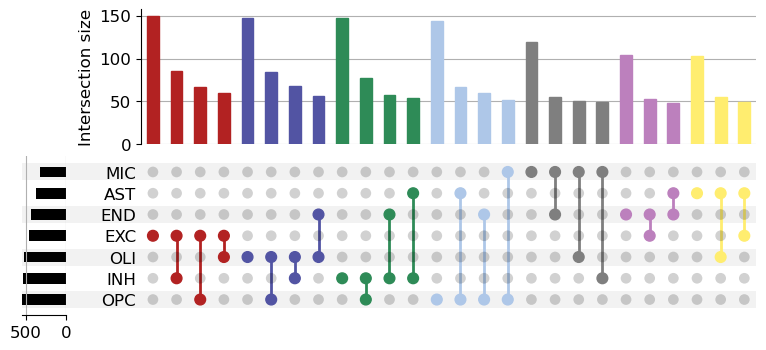

In [22]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = '12'
upset = UpSet(ex,sort_by=None,element_size=22)
upset.style_subsets(present=['EXC'],absent=['AST','END','MIC'],facecolor='#b22222')
upset.style_subsets(present=['OLI'],absent=['AST','MIC','EXC'],facecolor='#5254a3')
upset.style_subsets(present=['INH'],absent=['OLI','MIC','EXC'],facecolor='#2E8B57')
upset.style_subsets(present=['OPC'],absent=['OLI','EXC','INH'],facecolor='#aec7e8')
upset.style_subsets(present=['MIC'],absent=['OPC','EXC','AST'],facecolor='#7f7f7f')
upset.style_subsets(present=['END'],absent=['OPC','OLI','INH','MIC'],facecolor='#bc80bd')
upset.style_subsets(present=['AST'],absent=['INH','MIC','OPC','END'],facecolor='#ffed6f')

upset.plot()

# Figure 4d: CREs donut plot

In [23]:
p2g = pd.read_csv('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/ATAC/data/p2glinks_maxDist_2M.csv',sep='\t')

In [24]:
p2g = p2g[p2g.Correlation > 0.4][p2g.FDR < 0.05]

/tmp/ipykernel_4051624/3968602141.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p2g = p2g[p2g.Correlation > 0.4][p2g.FDR < 0.05]


In [25]:
p2g = p2g.drop_duplicates(subset=['peakName'])

In [26]:
union = pd.read_csv('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/ATAC/data/peaks/union_peaks_meta.bed',sep='\t')

In [27]:
union = union[['peak','peakType']]

In [28]:
cre = union[union.peak.isin(p2g.peakName.values)].value_counts('peakType')

In [30]:
# percent CREs
round(union[union.peak.isin(p2g.peakName.values)].shape[0]/union.shape[0],2)

0.89

In [31]:
c='#b22222'
colors = []
for a in [1,0.7,0.1,0.4]:
    color = (np.append(list(matplotlib.colors.to_rgb(c)),a))
    colors.append(color)

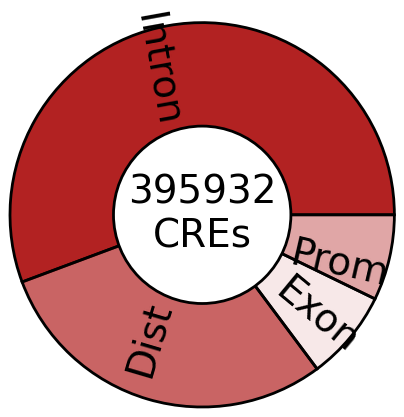

In [34]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = '28'

names = cre.index.values
size = cre.values
 
# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.6, edgecolor='k', facecolor='white', linewidth=2)

# Custom wedges
fig, ax = plt.subplots()
pie, text = ax.pie(size, labels=['Intron','Dist','Exon','Prom'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'black' }, colors=colors, rotatelabels=True,labeldistance=0.45, radius=1.3)

p=plt.gcf()
p.gca().add_artist(my_circle)

ax.text(0., 0., str(cre.values.sum())+'\nCREs', horizontalalignment='center', verticalalignment='center')
plt.savefig('/home/ah2428/CRE_categories.pdf',bbox_inches='tight',dpi=300)

# Figure 4e: CLG DEG venn diagrams 

/tmp/ipykernel_4051624/3875226553.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_enh = p2g_all[p2g_all.FDR < 0.05][np.abs(p2g_all.Correlation) > 0.4]


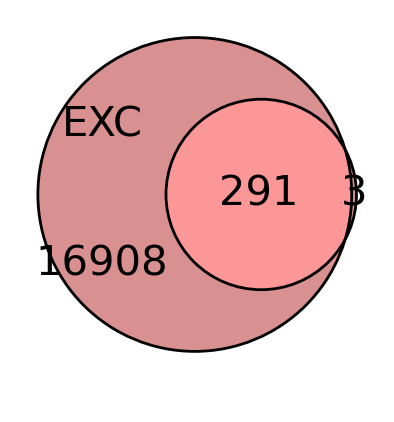

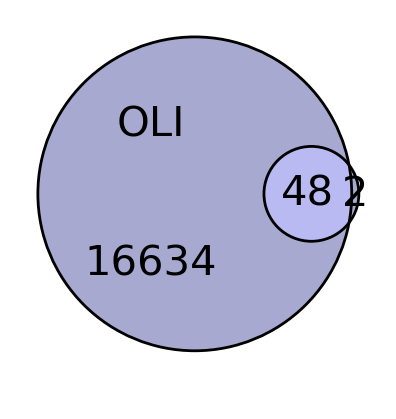

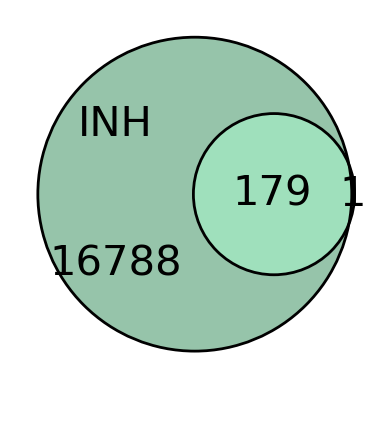

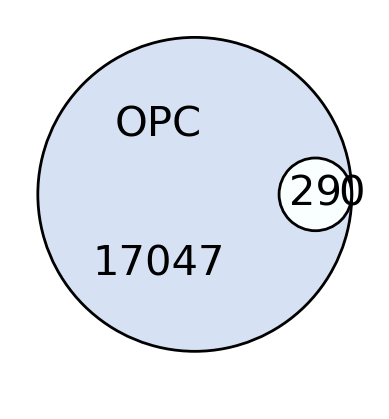

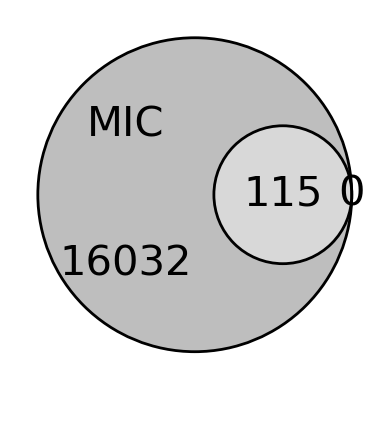

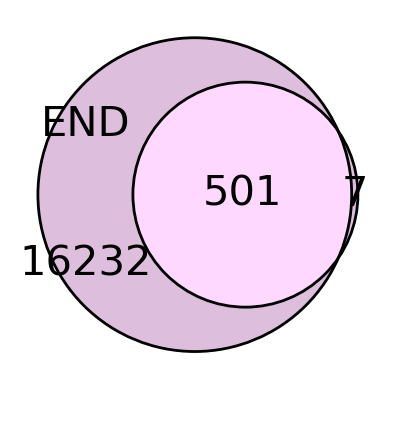

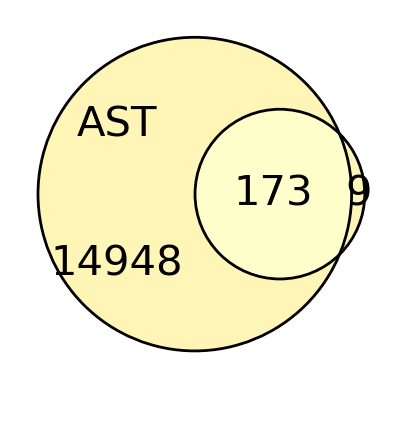

In [36]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.rcParams['font.size'] = '30'
colors = [celltype_colors[i] for i in celltypes]

p2g_all = pd.read_csv('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/ATAC/data/p2glinks_maxDist_2M.csv',sep='\t')
med_enh = p2g_all[p2g_all.FDR < 0.05][np.abs(p2g_all.Correlation) > 0.4]

percents = []
num_inters = []
inter_genes = []
for ii,cell in zip(np.arange(len(celltypes)),celltypes):
    cell_peaks = pd.read_csv(f'/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/ATAC/data/peaks/{cell}.peaks.bed',sep='\t',header=None)[3].values
    cell_p2g = med_enh[med_enh.peakName.isin(cell_peaks)]
    elg = cell_p2g.geneName.unique()
    deg_up = pd.read_csv(f'/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/RNA/mast_wilcox_intersected_DEG/{cell}_PTSD_UP.csv',header=None)[0].values
    deg_down = pd.read_csv(f'/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/RNA/mast_wilcox_intersected_DEG/{cell}_PTSD_DOWN.csv',header=None)[0].values
    deg = list(set(np.append(deg_up,deg_down)))
    deg = [x for x in deg if x in protein_coding]
    inter = list(set(elg)&set(deg))
    inter_genes.append(inter)
    percents.append(len(inter)/len(deg))
    num_inters.append(len(inter))
    plt.figure()
    v = venn2(subsets = ( (len(elg)-len(inter))*0.03, len(deg)-len(inter), len(inter)),
        set_colors=(colors[ii],colors[ii]),
        set_labels=(' ',' '),
        alpha=0.5,
    )
    c = venn2_circles(subsets = ( (len(elg)-len(inter))*0.03, len(deg)-len(inter), len(inter)),color='black')

    v.get_label_by_id('10').set_text(str(len(elg)-len(inter)))
    v.get_label_by_id('100').set_text(f'{cell}\n\n\n{len(elg)-len(inter)}')

In [41]:
# how many upregulated/downregulated? 

percents = []
num_inters = []
inter_genes = []
for ii,cell in zip(np.arange(len(celltypes)),['EXC','INH','OLI','OPC','END','AST','MIC']):
    cell_peaks = pd.read_csv(f'/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/ATAC/data/peaks/{cell}.peaks.bed',sep='\t',header=None)[3].values
    cell_p2g = med_enh[med_enh.peakName.isin(cell_peaks)]
    elg = cell_p2g.geneName.unique()
    deg_up = pd.read_csv(f'/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/RNA/mast_wilcox_intersected_DEG/{cell}_PTSD_UP.csv',header=None)[0].values
    deg_down = pd.read_csv(f'/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/RNA/mast_wilcox_intersected_DEG/{cell}_PTSD_DOWN.csv',header=None)[0].values
    
    inter_up = list(set(elg)&set(deg_up))
    inter_down = list(set(elg)&set(deg_down))
    
    deg = list(set(np.append(deg_up,deg_down)))
    deg = [x for x in deg if x in protein_coding]
    inter = list(set(elg)&set(deg))
    print(cell,len(inter_up),len(inter_down),len(inter))
    inter_genes.append(inter)
    percents.append(len(inter)/len(deg))

EXC 224 67 291
INH 77 102 179
OLI 10 38 48
OPC 13 16 29
END 160 341 501
AST 109 64 173
MIC 20 95 115


# Extended Data Figure 6d: CLG DEG intersected genes similarity matrix

In [43]:
arr = np.zeros((7,7))
for i in range(7):
    for j in range(7):
        n = len(list(set(inter_genes[i]) & set(inter_genes[j])))
        arr[i,j] = n

/tmp/ipykernel_4051624/2933765084.py:3: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(arr),cmap='Reds')


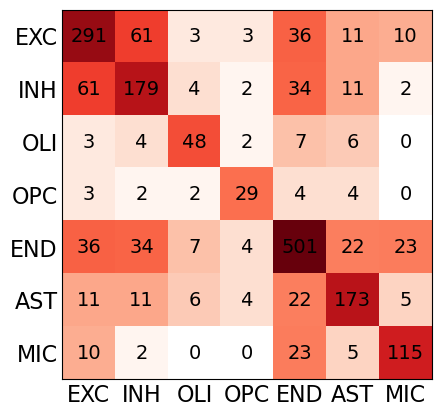

In [44]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.imshow(np.log(arr),cmap='Reds')
for i in range(7):
    for j in range(7):
        plt.text(i,j,int(arr[i,j]),ha="center", va="center",fontsize=14)
        
plt.xticks(np.arange(7),['EXC','INH','OLI','OPC','END','AST','MIC'],fontsize=16)
plt.yticks(np.arange(7),['EXC','INH','OLI','OPC','END','AST','MIC'],fontsize=16)

plt.tick_params(axis=u'both', which=u'both',length=0)

In [45]:
for ii,x in enumerate(inter_genes):
    if 'HDAC9' in x:
        print(ii)

4
6


# cell type-specific peaks?

In [28]:
p2g = pd.read_csv('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/ATAC/data/p2glinks_maxDist_2M.csv',sep='\t')

In [29]:
p2g = p2g[p2g.Correlation > 0.4][p2g.FDR < 0.05]

/tmp/ipykernel_2877526/3968602141.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p2g = p2g[p2g.Correlation > 0.4][p2g.FDR < 0.05]


In [30]:
fkbp5_peaks = p2g[p2g.geneName=='FKBP5']

In [31]:
fkbp5_peaks = fkbp5_peaks.drop_duplicates(subset=['peakName'])

In [32]:
fkbp5_peaks

idxATAC  idxRNA  Correlation           FDR  VarQATAC   VarQRNA   
11773461   160170   14610     0.695597  1.725312e-14  0.021794  0.961314  \
11773492   160201   14610     0.579588  2.315542e-09  0.179160  0.961314   
11773504   160213   14610     0.470485  3.939026e-06  0.471641  0.961314   
11773505   160214   14610     0.637192  1.250140e-11  0.848795  0.961314   
11773506   160215   14610     0.413282  7.473654e-05  0.965077  0.961314   
...           ...     ...          ...           ...       ...       ...   
11774311   161020   14610     0.773446  1.356245e-19  0.916414  0.961314   
11774315   161024   14610     0.761812  1.043500e-18  0.377928  0.961314   
11774316   161025   14610     0.734125  8.652912e-17  0.184932  0.961314   
11774339   161048   14610     0.431497  3.108921e-05  0.955680  0.961314   
11774376   161085   14610     0.761031  1.191479e-18  0.646235  0.961314   

         geneName                peakName   chr     start       end  
11773461    FKBP5  chr6_33995778_33996278  chr6  33995778  33996278  
11773492    FKBP5  chr6_34182617_34183117  chr6  34182617  34183117  
11773504    FKBP5  chr6_34235205_34235705  chr6  34235205  34235705  
11773505    FKBP5  chr6_34235717_34236217  chr6  34235717  34236217  
11773506    FKBP5  chr6_34236567_34237067  chr6  34236567  34237067  
...           ...                     ...   ...       ...       ...  
11774311    FKBP5  chr6_37240129_37240629  chr6  37240129  37240629  
11774315    FKBP5  chr6_37269834_37270334  chr6  37269834  37270334  
11774316    FKBP5  chr6_37279699_37280199  chr6  37279699  37280199  
11774339    FKBP5  chr6_37432928_37433428  chr6  37432928  37433428  
11774376    FKBP5  chr6_37583157_37583657  chr6  37583157  37583657  

[223 rows x 11 columns]

In [45]:
hdac9 = p2g[p2g.geneName=='HDAC9']
hdac9 = hdac9.drop_duplicates(subset=['peakName'])

In [49]:
ybx3 = p2g[p2g.geneName=='YBX3']
ybx3 = ybx3.drop_duplicates(subset=['peakName'])

In [33]:
union = pd.read_csv('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/ATAC/data/peaks/union_peaks_meta.bed',sep='\t')

In [38]:
pd.set_option('display.max_rows', None)
union[union.peak.isin(fkbp5_peaks.peakName.values)].celltype.value_counts()

celltype
Mic    193
End     17
Ast      4
Oli      3
In       2
Ex       2
OPC      2
Name: count, dtype: int64

In [47]:
union[union.peak.isin(hdac9.peakName.values)].celltype.value_counts()

celltype
Ex     66
Mic    19
In     11
OPC     5
Name: count, dtype: int64

In [53]:
len(list(set(union[union.peak.isin(ybx3.peakName.values)].peak)))

290